## High-level settings, imports

In [1]:
import os
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torchvision.datasets import MNIST, FashionMNIST

n_epochs = 10
batch_size = 64
image_shape = (1, 28, 28)
output_classes = 10
device = 'cuda'
results_dir = os.path.join('.', 'results', 'mnist_antigan_features__2022_9_21_13_52_2', 'trial_0')
digitize_bits = None
dataset = MNIST
dataset_path = os.path.join('.', 'saved_datasets', 'MNIST')

## Initialize discriminator model

## Initialize datasets and dataloaders

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

training_dataset = dataset(
    root=dataset_path,
    train=True,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
testing_dataset = dataset(
    root=dataset_path,
    train=False,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
training_dataloader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
testing_dataloader = DataLoader(testing_dataset, shuffle=False, batch_size=batch_size)

## Load trained generator

In [3]:
from models.lenet_gan import SimpleGen

gen = SimpleGen(
    latent_dims=100,
    label_dims=10,
    output_shape=(batch_size, *image_shape),
    output_classes=10)
gen.load_state_dict(torch.load(os.path.join(results_dir, 'trained_generator')))
gen.eval()

print(gen)

SimpleGen(
  (feature_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
  )
  (label_encoder): Sequential(
    (0): Embedding(10, 10)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=9, bias=True)
  )
  (latent_encoder): Sequential(
    (0): Linear(in_features=100, out_features=216, bias=True)
    (1): ReLU()
    (2): Linear(in_features=216, out_features=108, bias=True)
  )
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(45, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 

## Define training functions

In [11]:
from models.lenet5 import LeNet5

def digitize_image(image):
    image = 255*(.5*image+.5)
    image = image.to(torch.uint8)
    image = image.to(torch.float32)
    image = 2*(image/255)-1
    return image

def get_protected_images(images, labels, override_device=None):
    if override_device is not None:
        latent = torch.randn(batch_size, 100, device=override_device)
        masks = gen.to(override_device)(latent, labels, images)
    else:
        latent = torch.randn(batch_size, 100, device=device)
        masks = gen.to(device)(latent, labels, images)
    protected_images = torch.tanh(images + nn.functional.hardtanh(masks))
    protected_images = digitize_image(protected_images)
    return protected_images

def get_noisy_images(images, *args, override_device=None):
    if override_device is not None:
        noise = 2*torch.rand(images.shape, device=override_device)-1
    else:
        noise = 2*torch.rand(images.shape, device=device)-1
    noisy_images = torch.tanh(images + noise)
    noisy_images = digitize_image(noisy_images)
    return noisy_images

def process_batch(batch, process_image_fn=None, override_device=None):
    images, labels = batch
    images = images.to(override_device if override_device is not None else device)
    labels = labels.to(override_device if override_device is not None else device)
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device=override_device)
    return images, labels

def train_step(disc, loss_fn, optimizer, batch, process_image_fn=None):
    images, labels = process_batch(batch, process_image_fn)
    logits = disc(images)
    loss = loss_fn(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

@torch.no_grad()
def eval_step(disc, loss_fn, batch, process_image_fn=None, override_device=None):
    images, labels = process_batch(batch, process_image_fn, override_device=override_device)
    logits = disc(images)
    loss = loss_fn(logits, labels).cpu().numpy()
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    acc = np.mean(np.equal(predictions, labels.cpu().numpy()))
    return loss, acc

@torch.no_grad()
def get_confusion_matrix(disc, batch, process_image_fn=None, override_device=None):
    images, labels = process_batch(batch, process_image_fn, override_device=override_device)
    logits = disc(images)
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    confusion_matrix = np.zeros((10, 10))
    for label, prediction in zip(labels.cpu().numpy(), predictions):
        confusion_matrix[label][prediction] += 1./np.count_nonzero(labels==label)
    confusion_matrix *= (10/labels.size(0))
    return confusion_matrix

def get_confusion_matrix_epoch(disc, dataloader, process_image_fn=None, override_device=None):
    confusion_matrices = []
    for batch in dataloader:
        confusion_matrix = get_confusion_matrix(disc, batch, process_image_fn=process_image_fn, override_device=override_device)
        confusion_matrices.append(confusion_matrix)
    averaged_confusion_matrix = np.mean(confusion_matrices, axis=0)
    return averaged_confusion_matrix

def train_epoch(disc, loss_fn, optimizer, dataloader, process_image_fn=None):
    for batch in dataloader:
        train_step(disc, loss_fn, optimizer, batch, process_image_fn=process_image_fn)

def eval_epoch(disc, loss_fn, dataloader, process_image_fn=None, override_device=None):
    losses, accs = [], []
    for batch in dataloader:
        loss, acc = eval_step(disc, loss_fn, batch, process_image_fn=process_image_fn, override_device=override_device)
        losses.append(loss)
        accs.append(acc)
    return np.mean(losses), np.mean(accs)

def train_disc(process_image_fn=None):
    disc = LeNet5(
        input_shape=(batch_size, *image_shape),
        output_classes=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(disc.parameters())
    
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    progress_bar = tqdm(total=3*n_epochs+2)
    def eval_performance():
        nonlocal train_losses, train_accs, test_losses, test_accs
        train_loss, train_acc = eval_epoch(disc, loss_fn, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        test_loss, test_acc = eval_epoch(disc, loss_fn, testing_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    eval_performance()
    for epoch in range(n_epochs):
        train_epoch(disc, loss_fn, optimizer, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        eval_performance()
    return np.array(train_losses), np.array(train_accs), np.array(test_losses), np.array(test_accs), disc

def display_disc_performance(process_image_fn=None):
    train_losses, train_accs, test_losses, test_accs, disc = train_disc(process_image_fn=process_image_fn)
    (fig, axes) = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(train_losses, '--', color='blue', label='Training losses')
    axes[0].plot(test_losses, '-', color='blue', label='Testing losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over time')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].plot(1-train_accs, '--', color='blue', label='Training accuracies')
    axes[1].plot(1-test_accs, '-', color='blue', label='Testing accuracies')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Error rate')
    axes[1].set_title('Error rate over time')
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].grid(True)
    fig.suptitle('Independent discriminator performance: {}'.format(process_image_fn))
    plt.tight_layout()
    return disc, (train_losses, train_accs, test_losses, test_accs)

def display_images(process_image_fn=None):
    batch = next(iter(testing_dataloader))
    images, labels = batch
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device='cpu')
    images_to_show = {}
    for idx in range(10):
        for label, image in zip(labels, images):
            if label == idx:
                images_to_show[idx] = image
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for ax, (label, image) in zip(axes.flatten(), images_to_show.items()):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap='binary', aspect='equal', interpolation='none')
        ax.axis('off')
        ax.set_title('Label: {}'.format(label))
    plt.tight_layout()

def display_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(confusion_matrix, cmap='binary', aspect='equal', interpolation='none')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Ground truth')
    plt.tight_layout()
    return ax

## Train discriminator on noise-free data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:46<00:00,  5.22s/it]


(array([2.3028252, 1.4862517, 1.4813304, 1.4770597, 1.4755628, 1.4776986,
       1.4799553, 1.4732494, 1.473179 , 1.4724225, 1.4803667],
      dtype=float32), array([0.06834688, 0.97649587, 0.98086021, 0.98472481, 0.98585754,
       0.98357543, 0.98142657, 0.98797308, 0.98808969, 0.988756  ,
       0.98056037]), array([2.3029442, 1.4842442, 1.4806149, 1.4777942, 1.4760956, 1.4816037,
       1.4789394, 1.4768832, 1.4750258, 1.4751787, 1.4817437],
      dtype=float32), array([0.06478901, 0.97790605, 0.98099124, 0.98377787, 0.98517118,
       0.97919984, 0.98228503, 0.984375  , 0.98596736, 0.98586783,
       0.97949841]))


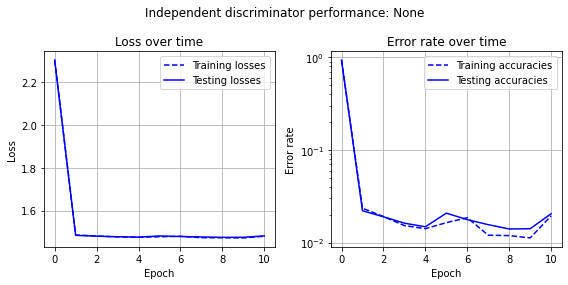

In [5]:
clean_disc, res = display_disc_performance()
print(res)

Clean discriminator loss: 1.4817436933517456, acc: 0.9794984076433121


Text(0.5, 1.0, 'Confusion matrix of fine-tuned discriminator')

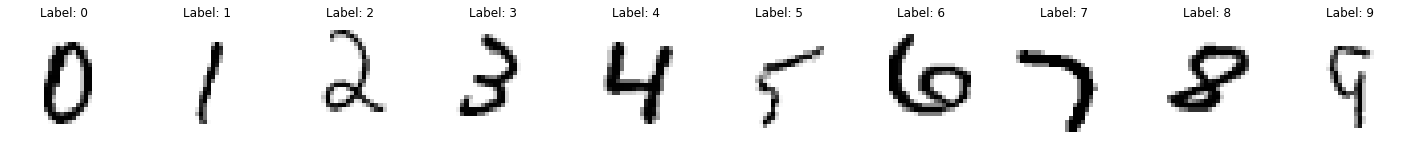

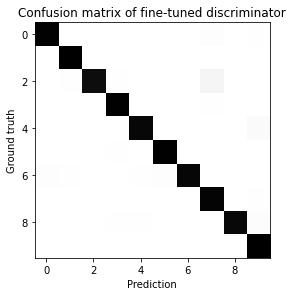

In [7]:
display_images()
loss, acc = eval_epoch(clean_disc.to('cpu'), nn.CrossEntropyLoss(), testing_dataloader, override_device='cpu')
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))
conf_mtx = get_confusion_matrix_epoch(clean_disc.to('cpu'), testing_dataloader, override_device='cpu')
ax = display_confusion_matrix(conf_mtx)
ax.set_title('Confusion matrix of fine-tuned discriminator')

## Train discriminator on data with uniform noise

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:49<00:00,  5.31s/it]


(array([2.3027363, 1.5015343, 1.4896028, 1.485027 , 1.4890997, 1.4820882,
       1.4800568, 1.4796145, 1.4789133, 1.4767423, 1.4792447],
      dtype=float32), array([0.08595416, 0.96162047, 0.97253132, 0.97652918, 0.97241471,
       0.97921109, 0.98129331, 0.98167644, 0.98257596, 0.9844916 ,
       0.98222615]), array([2.3027368, 1.496335 , 1.4883451, 1.4828742, 1.486636 , 1.4806242,
       1.4811724, 1.4798163, 1.4799411, 1.4780911, 1.4812219],
      dtype=float32), array([0.08290207, 0.96755573, 0.97372611, 0.97870223, 0.9750199 ,
       0.98069268, 0.97999602, 0.98158838, 0.9807922 , 0.98328025,
       0.98019506]))


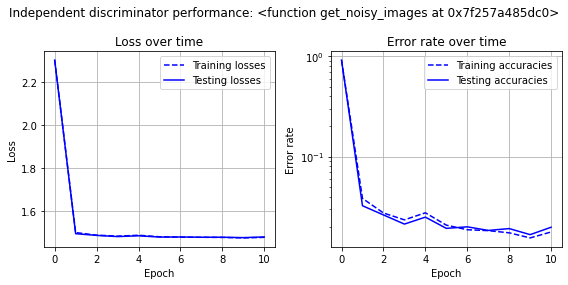

In [8]:
noisy_disc, res = display_disc_performance(get_noisy_images)
print(res)

Clean discriminator loss: 1.509429931640625, acc: 0.95203025477707
Fine-tuned discriminator loss: 1.4794282913208008, acc: 0.9817874203821656


Text(0.5, 1.0, 'Confusion matrix of fine-tuned discriminator')

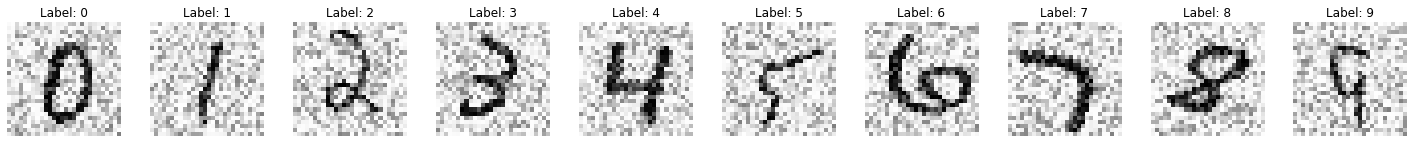

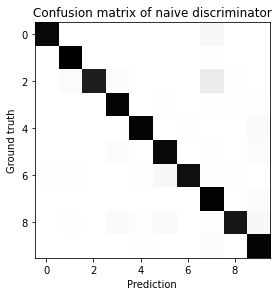

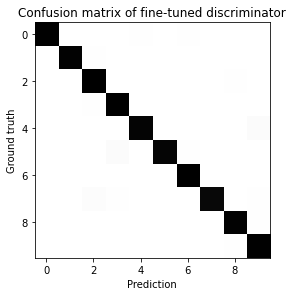

In [9]:
display_images(get_noisy_images)
loss, acc = eval_epoch(clean_disc.to('cpu'), nn.CrossEntropyLoss(), testing_dataloader, get_noisy_images, override_device='cpu')
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))
loss, acc = eval_epoch(noisy_disc.to('cpu'), nn.CrossEntropyLoss(), testing_dataloader, get_noisy_images, override_device='cpu')
print('Fine-tuned discriminator loss: {}, acc: {}'.format(loss, acc))
conf_mtx = get_confusion_matrix_epoch(clean_disc.to('cpu'), testing_dataloader, get_noisy_images, override_device='cpu')
ax = display_confusion_matrix(conf_mtx)
ax.set_title('Confusion matrix of naive discriminator')
conf_mtx = get_confusion_matrix_epoch(noisy_disc.to('cpu'), testing_dataloader, get_noisy_images, override_device='cpu')
ax = display_confusion_matrix(conf_mtx)
ax.set_title('Confusion matrix of fine-tuned discriminator')

## Train discriminator on data with generated mask


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [03:11<00:00,  6.00s/it]


(array([2.302514 , 1.9418182, 1.8744172, 1.8445566, 1.7922472, 1.7863438,
       1.7688797, 1.7800845, 1.7484584, 1.7583177, 1.7683887],
      dtype=float32), array([0.0988806 , 0.51829025, 0.58665378, 0.61535514, 0.66864339,
       0.67329091, 0.69076493, 0.68007063, 0.71133729, 0.70144256,
       0.6903818 ]), array([2.302693 , 1.9328194, 1.8662175, 1.8414477, 1.7896347, 1.7842827,
       1.7636867, 1.7774476, 1.7462306, 1.7523409, 1.7629377],
      dtype=float32), array([0.09006768, 0.53254379, 0.59444666, 0.6187301 , 0.67087978,
       0.6763535 , 0.69566083, 0.68242436, 0.71267914, 0.70800159,
       0.69605892]))


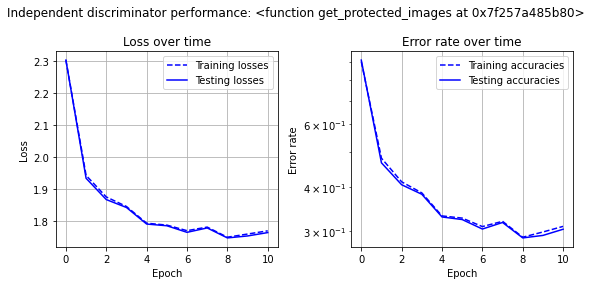

In [12]:
protected_disc, res = display_disc_performance(get_protected_images)
print(res)

Clean discriminator loss: 2.2519752979278564, acc: 0.20073646496815287
Fine-tuned discriminator loss: 1.7665904760360718, acc: 0.6921775477707006


Text(0.5, 1.0, 'Confusion matrix of fine-tuned discriminator')

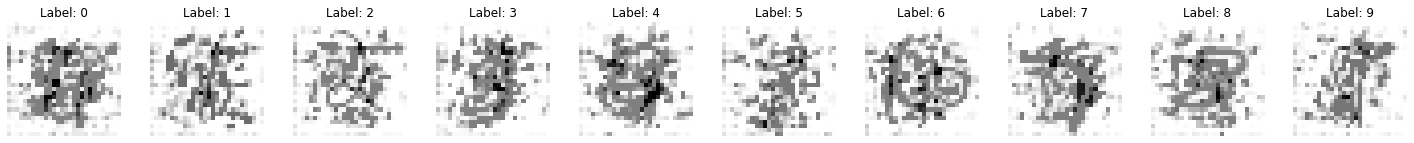

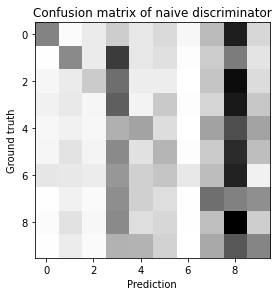

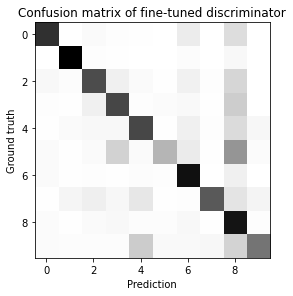

In [13]:
display_images(get_protected_images)
loss, acc = eval_epoch(clean_disc.to('cpu'), nn.CrossEntropyLoss(), testing_dataloader, get_protected_images, override_device='cpu')
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))
loss, acc = eval_epoch(protected_disc.to('cpu'), nn.CrossEntropyLoss(), testing_dataloader, get_protected_images, override_device='cpu')
print('Fine-tuned discriminator loss: {}, acc: {}'.format(loss, acc))
conf_mtx = get_confusion_matrix_epoch(clean_disc.to('cpu'), testing_dataloader, get_protected_images, override_device='cpu')
ax = display_confusion_matrix(conf_mtx)
ax.set_title('Confusion matrix of naive discriminator')
conf_mtx = get_confusion_matrix_epoch(protected_disc.to('cpu'), testing_dataloader, get_protected_images, override_device='cpu')
ax = display_confusion_matrix(conf_mtx)
ax.set_title('Confusion matrix of fine-tuned discriminator')